# DataPreprocessing

Part of data preprocessing has been done during the data colletion phase. In this notebook we start exploring more deeply the available data and perform some further preprocessing steps.

In [1]:
import pandas as pd
import numpy as np
from scipy import signal
pd.options.mode.chained_assignment = None

from datetime import timedelta
# graphics settings
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcdefaults()
plt.style.use('fivethirtyeight')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams.update({'font.size': 16})

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load data as produced by DataCollection
fullData = pd.read_csv("../data/tsData.csv")
fullData["created_at"] = pd.to_datetime(fullData["created_at"])
fullData.set_index("created_at", inplace=True)

## Missing values

Can happen to have sensors not recording any information for a more or less long period of time. From our perspective this translates in a missing value. We perform a first exploratory analysis to inspect the distribution of missing values 

In [3]:
# compute for each series the percentage of missing values
missing = {}

groupedData = fullData.groupby('pot_id', as_index=False)

for potid, d in groupedData:
    missing[potid] = [potid, d["pm2p5SPS"].isna().sum(), len(d["pm2p5SPS"])]

missingDF = pd.DataFrame(missing.values(), columns=["pot_id", "missing", "total"])
missingDF["percentage"] = missingDF["missing"]/missingDF["total"]
missingDF = missingDF.sort_values("percentage", ascending=False)

missingDF

,pot_id,missing,total,percentage
65,1511,360,370,0.972973
66,1515,357,369,0.967480
67,1516,354,369,0.959350
69,1547,331,350,0.945714
68,1520,347,369,0.940379
...,...,...,...,...
24,1043,97,2935,0.033049
11,1020,83,3014,0.027538
5,1011,88,3203,0.027474
10,1018,54,3202,0.016864


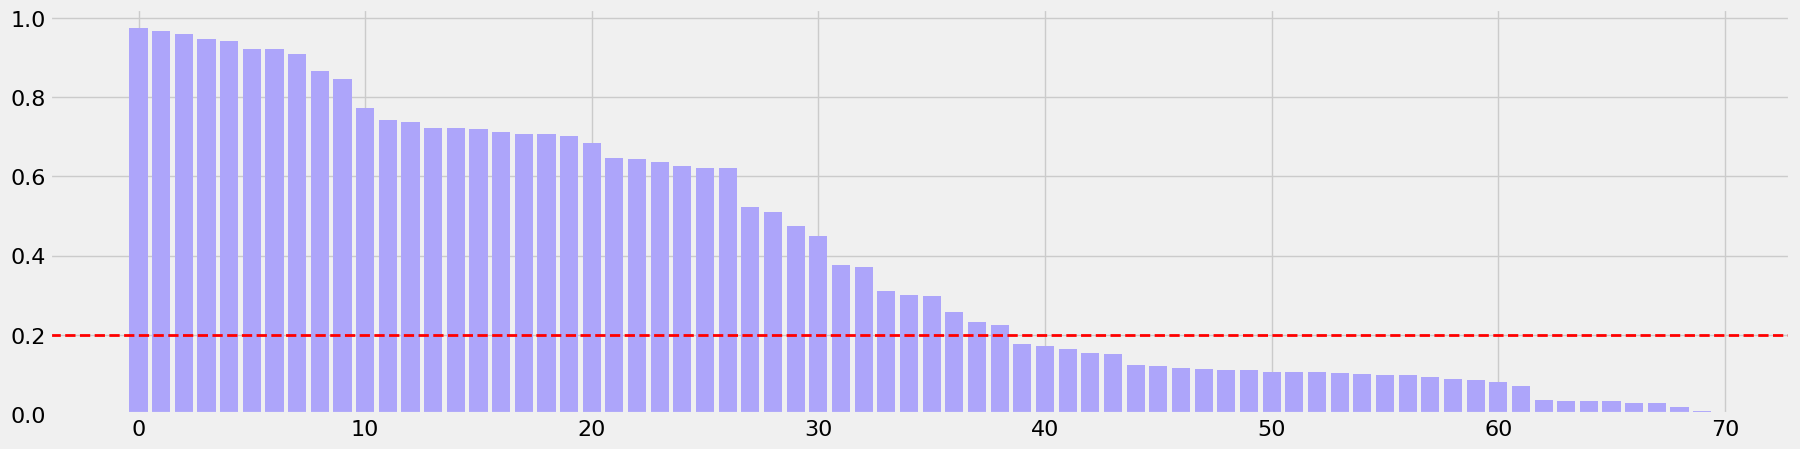

In [4]:
# graphically plot the distribution of missing values
plt.gcf().set_size_inches(20, 5)
plt.bar(range(len(missingDF)), missingDF["percentage"], color="#ada5fa")
plt.axhline(y=0.2, color="red", linestyle='dashed')
plt.show()

The above graph clearly shows that the majority of series have more than 20% of missing values. Clearly there are series which must discarded, for example pot 1511 has more than 97% of values missing. Totally useless.

It would be interesting to inspect the distribution of missing values as function of time.

In [5]:
# distribution of missing values in time
import calendar

# month: reference month 
# percentage: fraction of missing values concentrated in this month with respect to the overall dataset
# count: number of series having more than treshold value missing in this month
# potPercentage: count/(active number of sensors in this month)
def missingTimeDistribution(data, treshold):
    minMonth = data.index.min()
    maxMonth = data.index.max()
    missingByMonth = pd.DataFrame(columns=["month", "percentage", "count", "potPercentage"])

    totMissing = data["pm2p5SPS"].isna().sum()

    for i in range(minMonth.month, maxMonth.month):
        # filter data by month
        tmp = data.loc[fullData.index.month == i]

        # group data by pot_id
        tmpGrouped = tmp.groupby('pot_id', as_index=False)

        # count the number of pot which have more than treshold missing values
        count = 0
        for potid, d in tmpGrouped:
            if d["pm2p5SPS"].isna().sum()/len(d.index) >= treshold:
                count = count + 1

        missingByMonth = missingByMonth.append({"month": calendar.month_name[i], 
                                                "percentage": tmp["pm2p5SPS"].isna().sum()/totMissing, 
                                                "count": count,
                                                "potPercentage": count/len(tmp["pot_id"].unique())},
                                              ignore_index = True)
    return missingByMonth
        
missingTimeDistribution(fullData, 0.4)

,month,percentage,count,potPercentage
0,June,0.010765,3,0.100000
1,July,0.244644,36,0.580645
2,August,0.313287,27,0.435484
3,September,0.253314,27,0.421875
4,October,0.164075,17,0.242857


The summer period is the worst. For example approximately 60% of the time series have more than 40% of missing values in July. We can also inspect if there are series with 100% of value missing

In [6]:
missingTimeDistribution(fullData, 1)

,month,percentage,count,potPercentage
0,June,0.010765,0,0.000000
1,July,0.244644,0,0.000000
2,August,0.313287,18,0.290323
3,September,0.253314,8,0.125000
4,October,0.164075,0,0.000000


## Univariate analysis

To understand the problem better and keep it simple, we will focus on just a single time series

In [7]:
# set pot, and period of time where consider data
interestingPot = 1068
startDate      = "2020-09-01"
endDate        = fullData.index.max()


data = fullData.loc[fullData["pot_id"]==interestingPot][startDate:endDate]

# create an auxiliary column, just for convenience
data["created_at"] = data.index
# drop useless features in this analysis
data.drop(["latitude", "longitude", "weekend"], axis = 1, inplace = True)

data.head()

,pot_id,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht,wind,rain,created_at
created_at,,,,,,,,,,
2020-09-01 00:00:00,1068,2.885517,3.413793,5.280,5.479655,15.483793,69.969655,1.5,0.0,2020-09-01 00:00:00
2020-09-01 01:00:00,1068,1.170000,2.000000,2.550,2.670000,14.920000,70.000000,1.3,0.0,2020-09-01 01:00:00
2020-09-01 02:00:00,1068,5.520000,5.000000,5.830,5.830000,13.690000,70.000000,0.8,0.0,2020-09-01 02:00:00
2020-09-01 03:00:00,1068,5.437931,5.172414,6.650,6.730690,13.792759,70.000000,0.5,0.0,2020-09-01 03:00:00
2020-09-01 04:00:00,1068,6.015667,6.066667,7.993,8.139333,13.720000,70.000000,0.1,0.0,2020-09-01 04:00:00


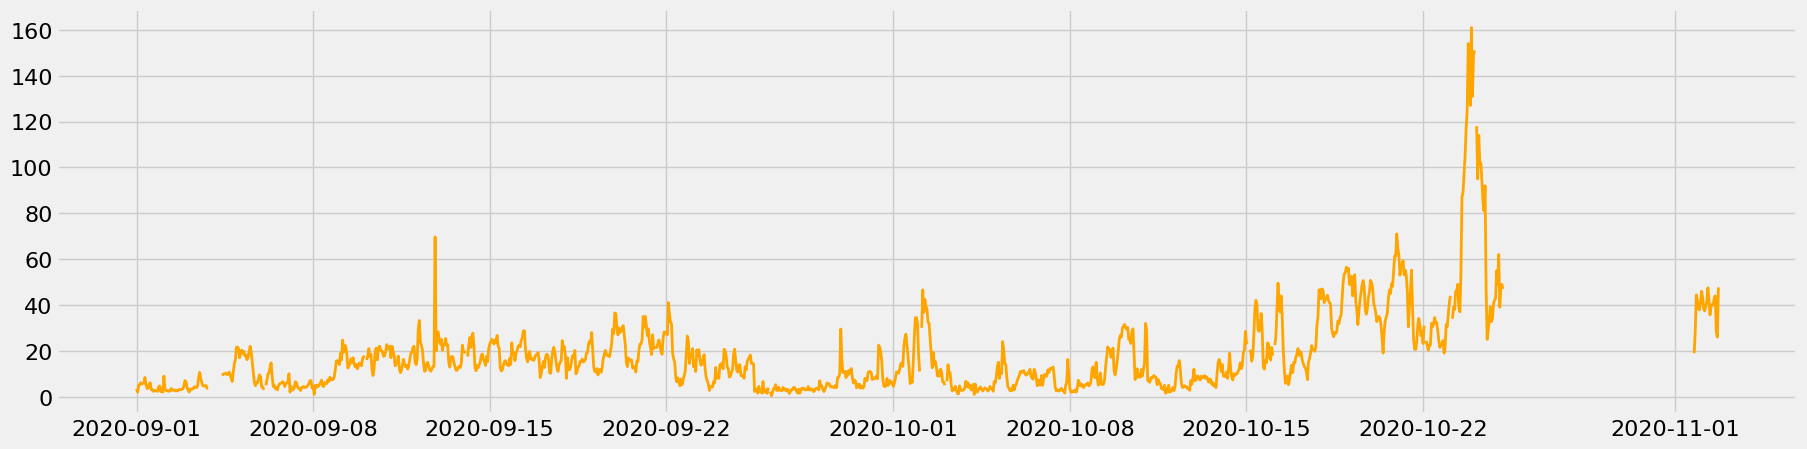

In [8]:
plt.gcf().set_size_inches(20, 5)
plt.plot(data["pm2p5SPS"], color="orange")
plt.show()

In [9]:
# percentage of missing values
data["pm2p5SPS"].isna().sum()/len(data["pm2p5SPS"])

0.13545816733067728

The series seems to have some seasonal pattern. To inspect this in more detail and get the period of the seasonal component we take the fourier transform of the process and look for interesting peaks

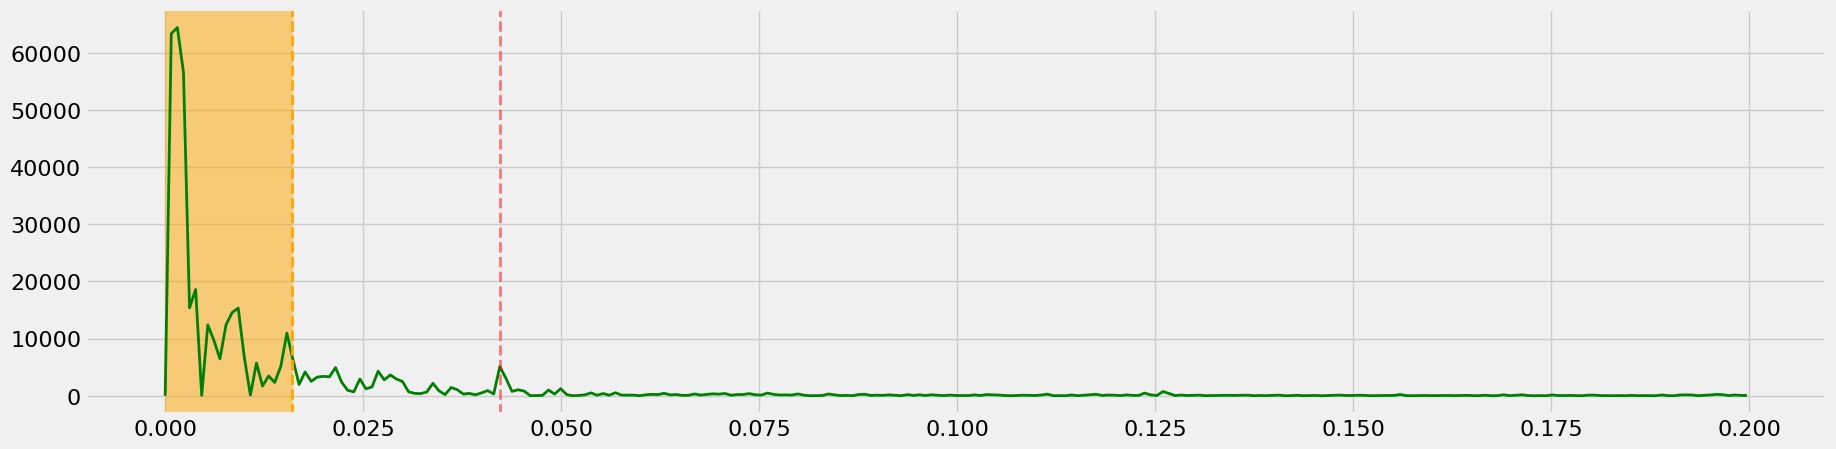

In [10]:
# missing values need to be dropped in order to compute process spectrum
dataNoNaN = data.dropna()
f, spectrum = signal.periodogram(dataNoNaN["pm2p5SPS"])

r = [freq for freq in f if freq < 0.2] # zoom the plot

plt.gcf().set_size_inches(20, 5)
plt.plot(r, spectrum[0:len(r)], color="green")

plt.axvline(x=0.016, color="orange", linestyle='dashed') # trend component
plt.axvspan(0, 0.016, color="orange", alpha=0.5)

plt.axvline(x=0.042243, color="red", linestyle='dashed', alpha=0.5)    # daily frequency
plt.show()

The red line corresponds to a signal component having period of 1 day. Note that in correspondance of this frequency we have a clear peak, showing that a daily seasonal component may be present.

Frequencies before the orange line correspond to periodic components havin a too long period, we think that those peaks are due to the series trend.

The following reports the most relevant periodic components (after the orange line) of the signal

In [11]:
topFreq = sorted(spectrum, reverse=True)[0:20]
fDF = pd.DataFrame(columns=["power", "freq", "period(hours)", "period(days)"])

for fr in topFreq:
    if(f[spectrum.tolist().index(fr)] > 0.016):
        fDF = fDF.append({"power" : fr, 
                          "freq" : f[spectrum.tolist().index(fr)], 
                          "period(hours)" : 1/f[spectrum.tolist().index(fr)],
                          "period(days)" : (1/f[spectrum.tolist().index(fr)])/24}
                          ,ignore_index=True)
fDF

,power,freq,period(hours),period(days)
0,6315.566264,0.016129,62.000000,2.583333
1,5104.821974,0.042243,23.672727,0.986364
2,4931.545918,0.021505,46.500000,1.937500
3,4293.652606,0.026882,37.200000,1.550000
4,4164.881290,0.017665,56.608696,2.358696


Using this information we can try to decompose the series setting a period of 24 hours

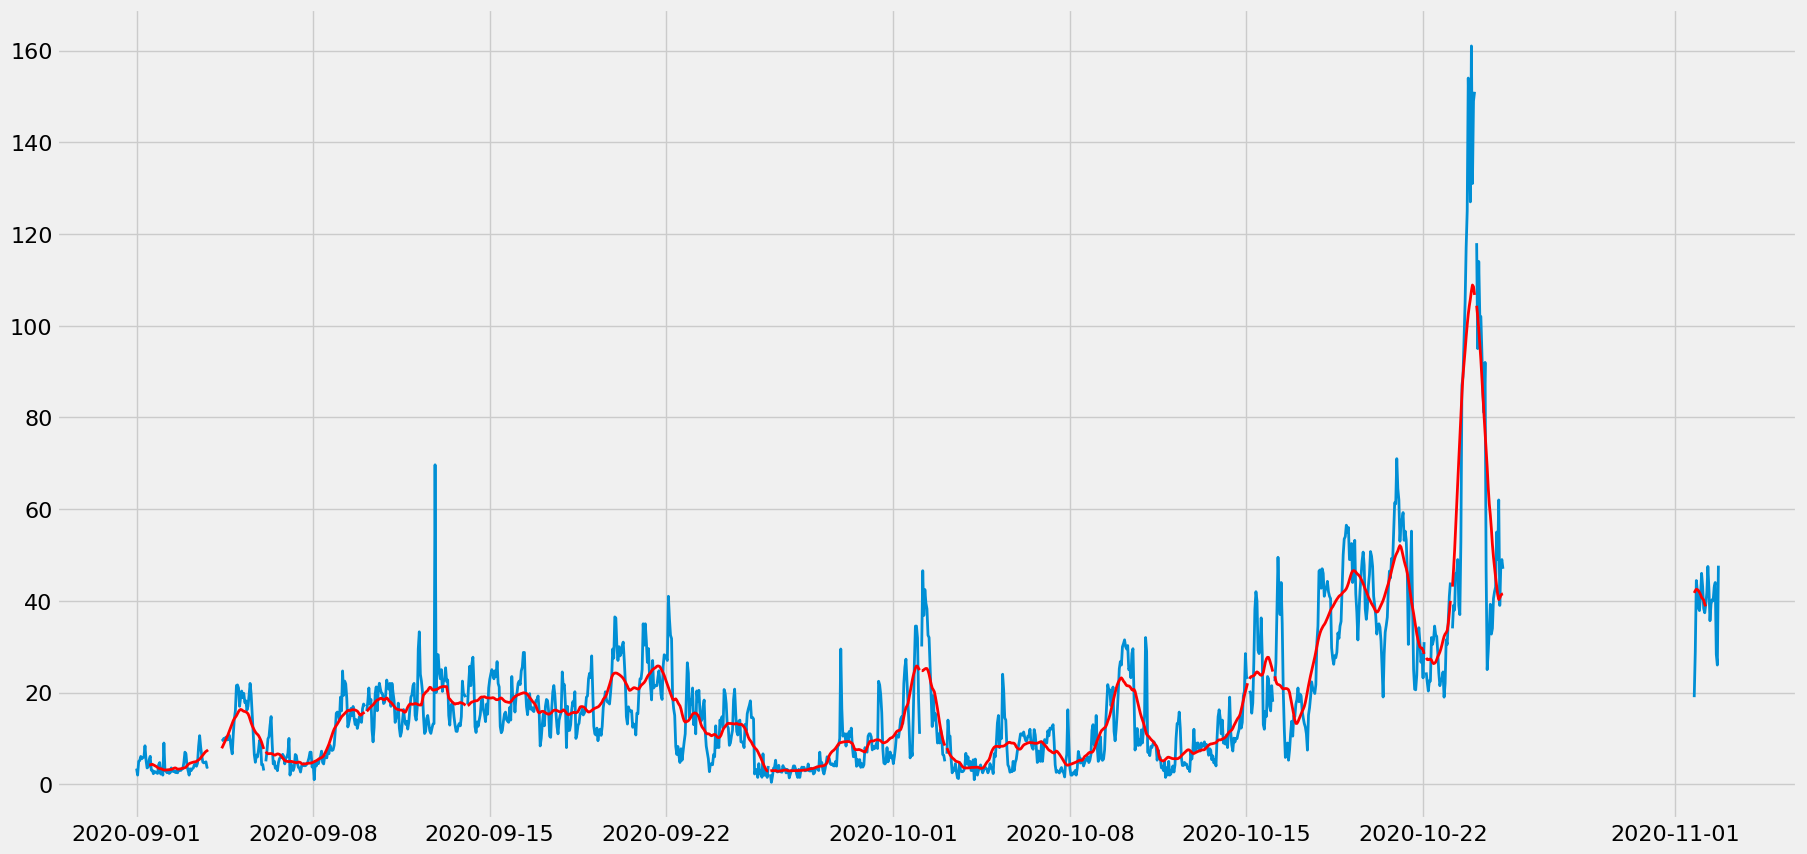

In [12]:
import statsmodels.api as sm
pm2p5TimeSeries = dataNoNaN["pm2p5SPS"]

decompose = sm.tsa.seasonal_decompose(pm2p5TimeSeries, freq=24)
decomposeResult = pd.DataFrame({"trend"    : decompose.trend,
                                "seasonal" : decompose.seasonal,
                                "residual" : decompose.resid})

# align the result of decomposition to the original dataset
decomposeResult = decomposeResult.reindex(pd.date_range(start   = data.index.min(),
                                                          end   = data.index.max(),
                                                          freq  = '1H'))

# plot data trend
plt.gcf().set_size_inches(20, 10)
plt.plot(data["pm2p5SPS"])
plt.plot(decomposeResult.trend, color="red", linewidth=2)
plt.show()

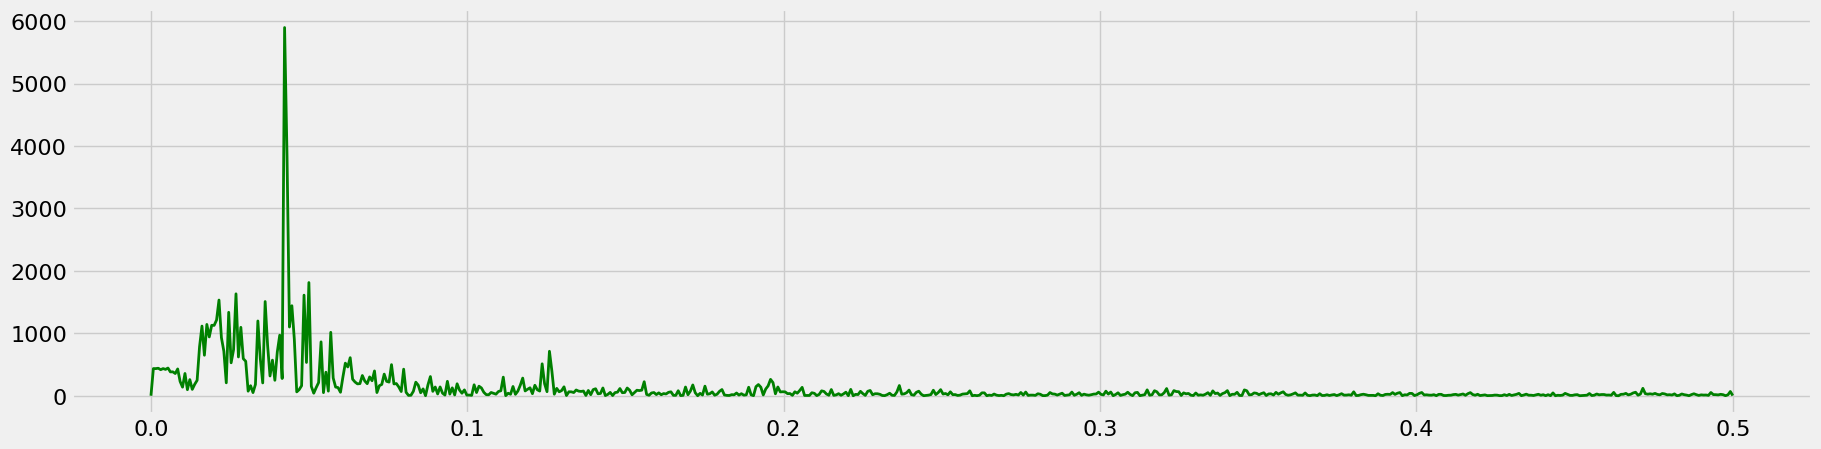

23.672727272727272


In [16]:
f, spectrum = signal.periodogram(pm2p5TimeSeries.subtract(decomposeResult.trend, fill_value=0).dropna())

plt.gcf().set_size_inches(20, 5)
plt.plot(f, spectrum, color="green")
plt.show()

print(1/f[np.argmax(spectrum)])

After removing the trend a clear peak corresponding to a daily periodical component remains in what is not captured by the trend. 
Hence we can assume a daily seasonality

## Solve missing values

da qui è uno schifo :)

In [19]:
# there is clearly a seasonality with a 24h period

# when a value is missing we act as follow:
# consider the same value in the series sampled at the same hour for different days
# average the results
# sum the obtained result to the actual trend

#def NaNresolve(data, decomposeResults):
tmp = fullData.loc[fullData["pot_id"]==1068]["2020-09-01":]

tmp = pd.concat([tmp, decomposeResult], join='inner', axis=1)
tmp.head()

#tmp["trend"].isna().sum()/len(tmp["trend"])

,pot_id,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht,latitude,longitude,weekend,wind,rain,trend,seasonal,residual
2020-09-01 00:00:00,1068,2.885517,3.413793,5.280,5.479655,15.483793,69.969655,NaN,NaN,0,1.5,0.0,NaN,-1.104047,NaN
2020-09-01 01:00:00,1068,1.170000,2.000000,2.550,2.670000,14.920000,70.000000,NaN,NaN,0,1.3,0.0,NaN,-0.780331,NaN
2020-09-01 02:00:00,1068,5.520000,5.000000,5.830,5.830000,13.690000,70.000000,NaN,NaN,0,0.8,0.0,NaN,-0.592710,NaN
2020-09-01 03:00:00,1068,5.437931,5.172414,6.650,6.730690,13.792759,70.000000,NaN,NaN,0,0.5,0.0,NaN,0.229909,NaN
2020-09-01 04:00:00,1068,6.015667,6.066667,7.993,8.139333,13.720000,70.000000,NaN,NaN,0,0.1,0.0,NaN,0.241213,NaN


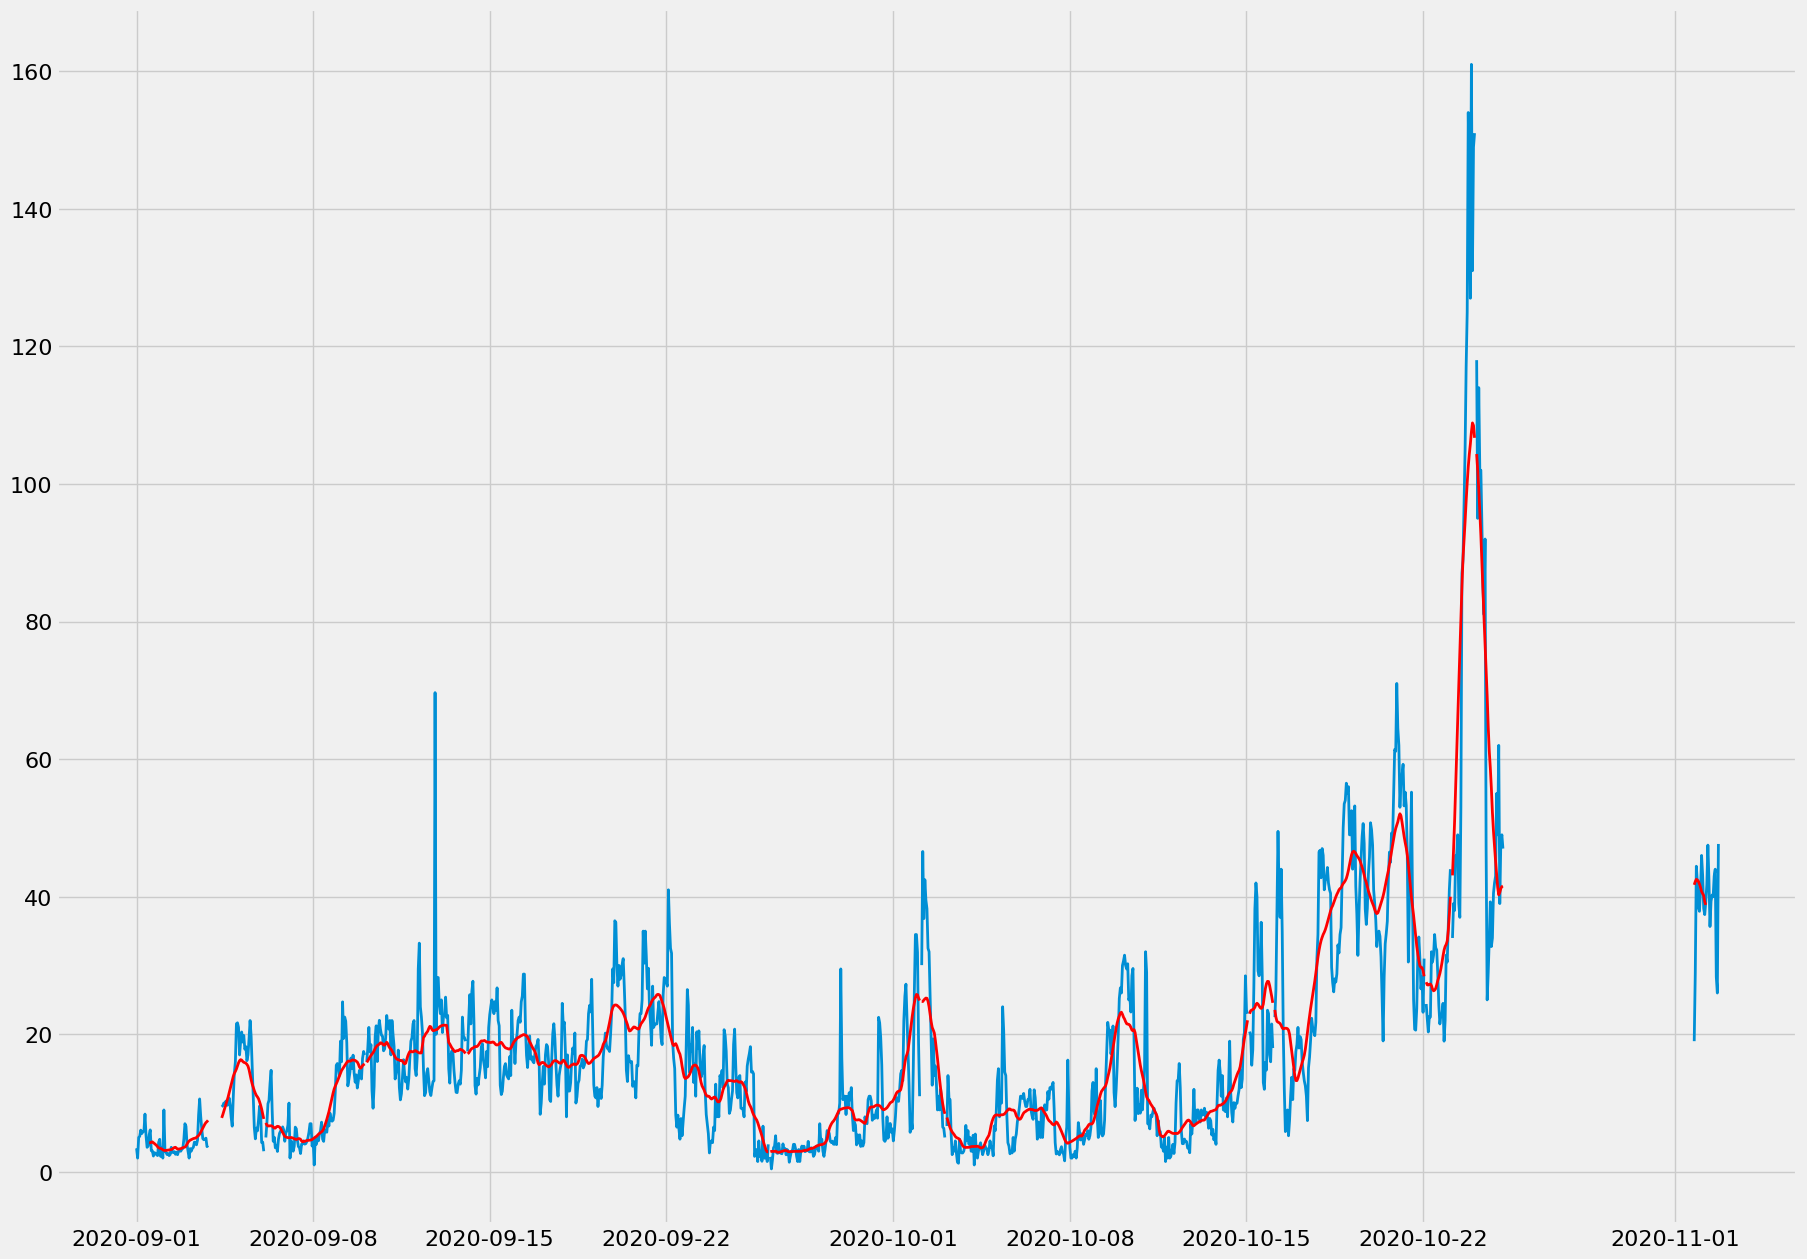

In [20]:
plt.gcf().set_size_inches(20, 15)
plt.plot(tmp["pm2p5SPS"])
plt.plot(tmp["trend"], color="red", linewidth=2)
plt.show()

In [21]:
# now need to interpolate the trend
before = tmp["trend"].isna().sum()/len(tmp["trend"])
tmp["trend"] = tmp["trend"].interpolate(method='spline', order=3)
after = tmp["trend"].isna().sum()/len(tmp["trend"])

print("before: "+str(before)+" after: "+str(after))

before: 0.15139442231075698 after: 0.00796812749003984


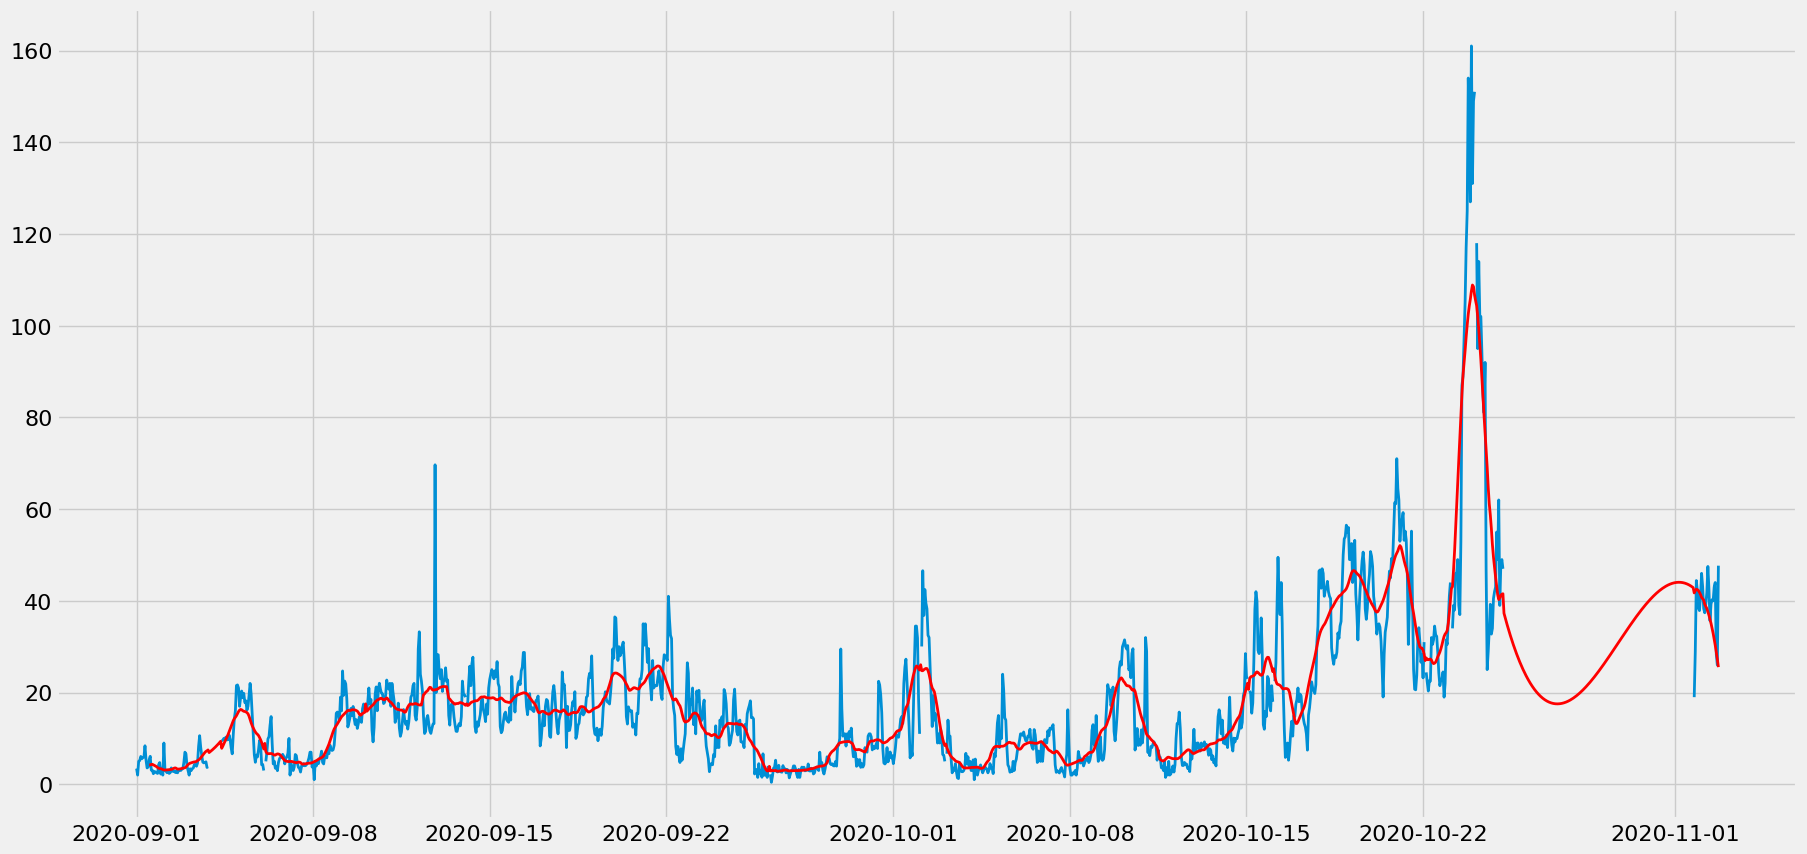

In [22]:
plt.gcf().set_size_inches(20, 10)
plt.plot(tmp["pm2p5SPS"])
plt.plot(tmp["trend"], color="red", linewidth=2)
plt.show()

In [23]:
# correct the values
import math

def correct(data, row, feature):
    if math.isnan(row[feature]):
        end = row["created_at"]
        start = end - timedelta(days = 7)
        # sample seasonal+noise values one week before
        datetimeIndex = pd.date_range(start, end, freq="24H")
        sampledData = data.loc[data.index.isin(datetimeIndex)]
        
        # compute the correction
        var = (sampledData["seasonal"].sum() + sampledData["residual"].sum())/len(sampledData.index)
        return row["trend"] + var
    else:
        # no missing, return the true value
        return row[feature]

tmp["created_at"] = tmp.index
res = tmp.apply(lambda row: correct(tmp, row, "pm2p5SPS"), axis = 1)
tmp.drop("created_at", axis = 1, inplace = True)

# store the corrected values
tmp["pm2p5SPS"] = res

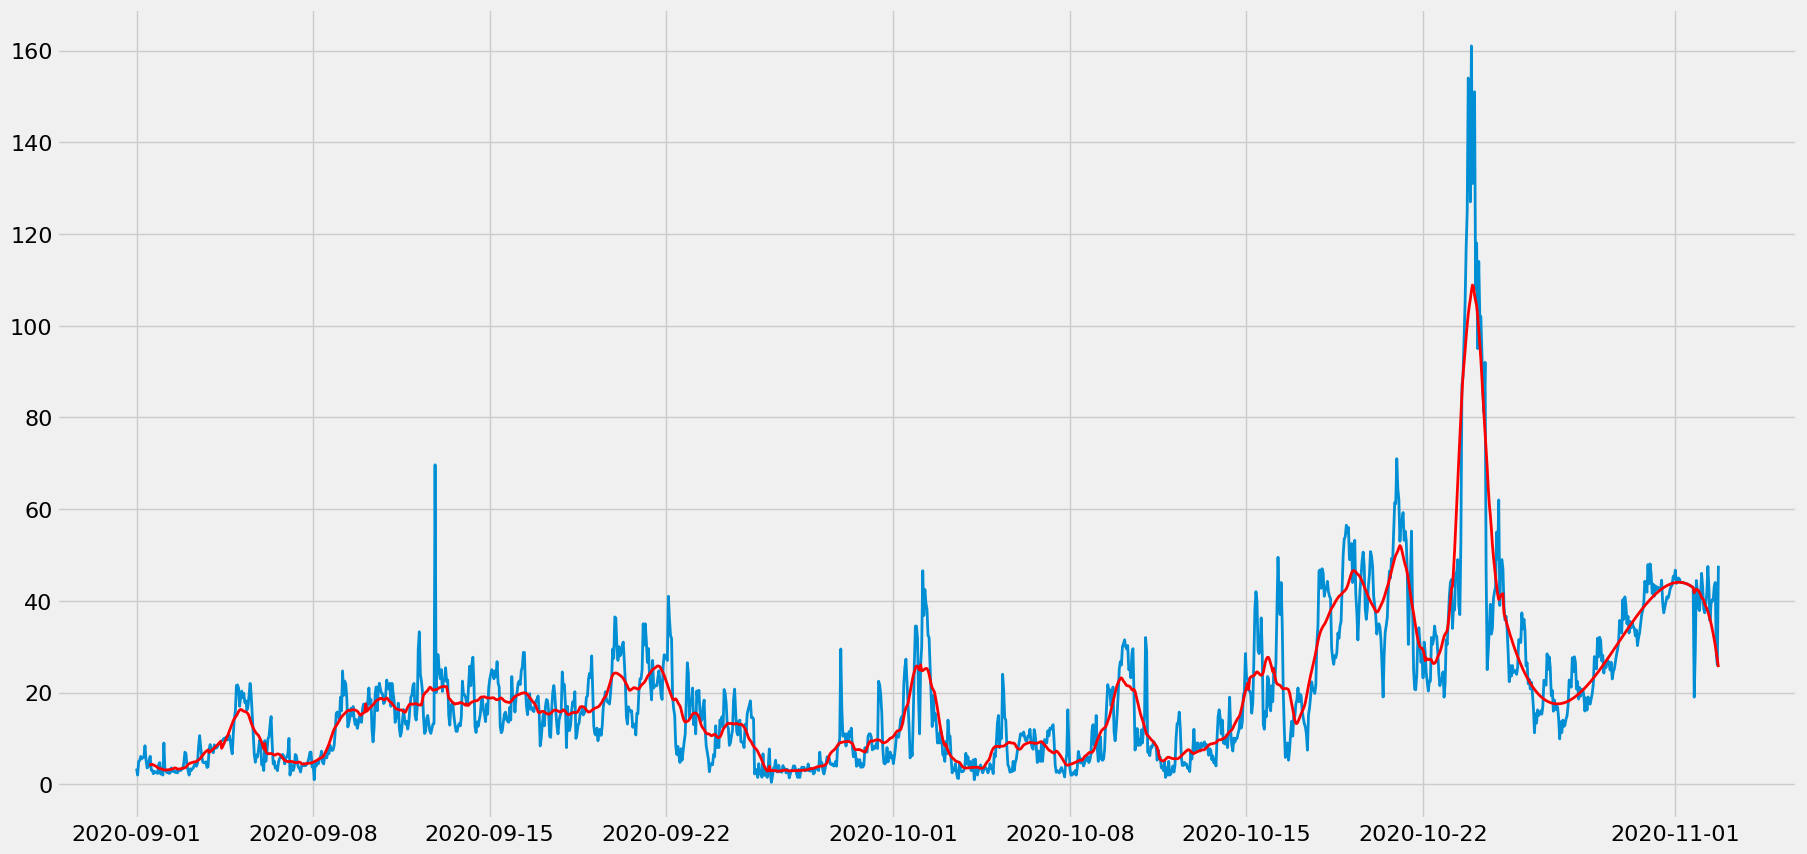

In [25]:
plt.gcf().set_size_inches(20, 10)
plt.plot(tmp["pm2p5SPS"])
plt.plot(tmp["trend"], color="red", linewidth=2)
plt.show()

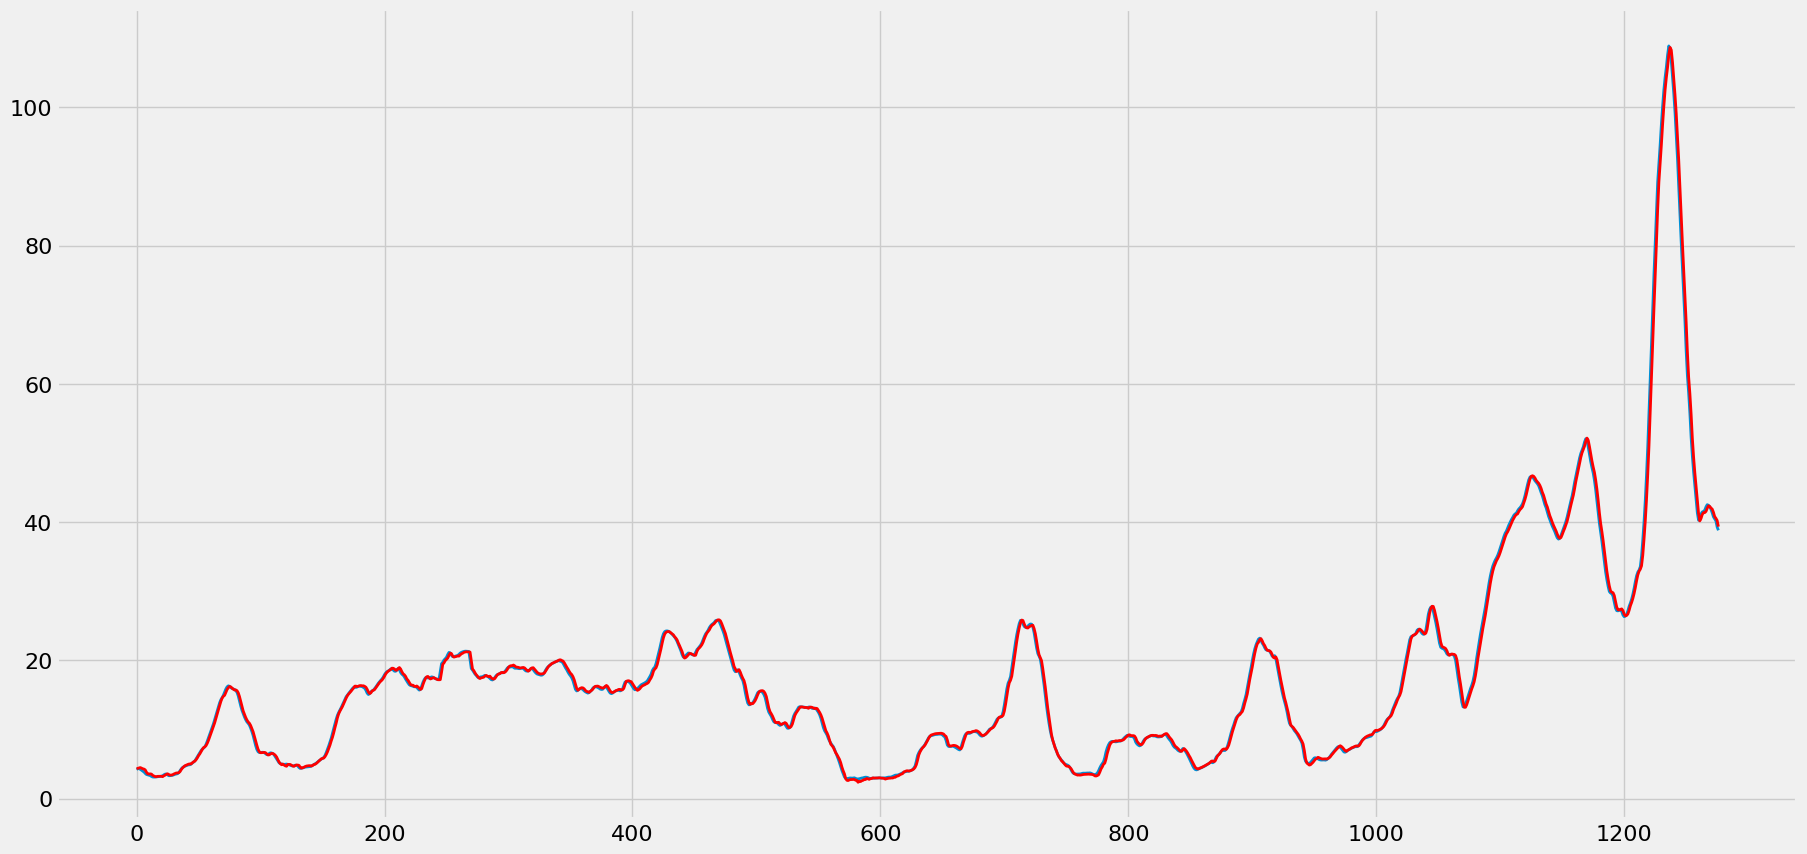

,temperature_sht,humidity_sht,weekend,wind,rain,trend-01
2020-09-01 13:00:00,22.612000,49.155667,0,1.6,0.0,4.231622
2020-09-01 14:00:00,23.003000,47.645000,0,1.6,0.0,4.233418
2020-09-01 15:00:00,23.269667,46.416667,0,1.9,0.0,4.316752
2020-09-01 16:00:00,23.427667,44.185333,0,1.9,0.0,4.355545
2020-09-01 17:00:00,23.643667,41.981333,0,1.7,0.0,4.243644
...,...,...,...,...,...,...
2020-11-02 01:00:00,9.350000,70.000000,0,0.4,0.0,41.347196
2020-11-02 02:00:00,10.725714,70.000000,0,0.8,0.0,40.763862
2020-11-02 03:00:00,11.028462,70.000000,0,0.4,0.2,40.472196
2020-11-02 04:00:00,10.218000,70.000000,0,0.5,0.0,40.166640


In [118]:
# modeling the trend

# we can try to model the trend with a linear model...

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

tmp = fullData.loc[fullData["pot_id"]==1068]["2020-09-01":]
tmp = pd.concat([tmp, decomposeResults], join='inner', axis=1)

tmp = tmp[tmp["trend"].notna()]


#tmp["pm2p5-01"] = tmp["pm2p5SPS"].shift()
tmp["trend-01"] = tmp["trend"].shift()

tmp.drop("latitude", axis = 1, inplace = True)
tmp.drop("longitude", axis = 1, inplace = True)
tmp.drop("pot_id", axis = 1, inplace = True)
tmp.drop("seasonal", axis = 1, inplace = True)
tmp.drop("residual", axis = 1, inplace = True)
tmp.drop("pm2p5SPS", axis = 1, inplace = True)
tmp.drop("pm1SPS", axis = 1, inplace = True)
tmp.drop("pm4SPS", axis = 1, inplace = True)
tmp.drop("pm10SPS", axis = 1, inplace = True)

tmp.dropna(inplace=True)
target = tmp["trend"].values

tmp.drop("trend", axis = 1, inplace = True)

model = Lasso(alpha = 0.01)
model.fit(tmp, target)

target_pred = model.predict(tmp)

plt.gcf().set_size_inches(20, 10)
plt.plot(target)
plt.plot(target_pred, color="red", linewidth=2)
plt.show()

tmp